In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import gan_helper
import sklearn.model_selection
import torch
import models
import util

GAN = gan_helper.Generator() # initializes gan


Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


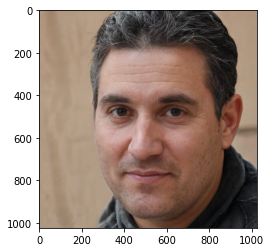

In [3]:
np.random.seed(13)
z = np.random.randn(1, 512)
images = GAN.gen(z)
plt.imshow(images[0])
plt.show()

# load latent-mapping model

In [5]:
PROCESSED_DIR = 'processed'
fname = '07_relu_retrain_3lay_noise_big'
df = pd.read_pickle(oj(PROCESSED_DIR, fname + '.pkl'))
p = pkl.load(open(oj(PROCESSED_DIR, fname + '_params.pkl'), 'rb'))
state_dicts = pkl.load(open(oj(PROCESSED_DIR, fname + '_weights.pkl'), 'rb'))

In [6]:
d = df[['epochs', 'mse_test', 'indep_corr_test']].infer_objects().round(2)
d[(d['mse_test'] < 0.5) & (d['indep_corr_test'] < 0.3)]

,epochs,mse_test,indep_corr_test
5,10000,0.3069094,0.28904143
6,12000,0.35443076,0.16762806
7,14000,0.4434507,0.058173716


In [9]:
key_epoch = 12000
state_dict = state_dicts[key_epoch]
device = 'cpu'
LATENT_DIM = 512
m = models.get_INN(num_layers=p['num_layers'], hidden_size=p['hidden_size'],
                   input_size=LATENT_DIM).to(device)
m.load_state_dict(state_dict)

Node 'coupling_0' takes the following inputs:
	 Output #0 of node 'input' with dims (512,)

Node 'coupling_1' takes the following inputs:
	 Output #0 of node 'coupling_0' with dims (512,)

Node 'coupling_2' takes the following inputs:
	 Output #0 of node 'coupling_1' with dims (512,)

Node 'output' takes the following inputs:
	 Output #0 of node 'coupling_2' with dims (512,)



<All keys matched successfully>

# let's start by looking at the distr of the predictions

In [10]:
RESULTS_DIR = 'results'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
annotations_dict_names = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict_names[k]
                    for k in annotations_dict_names}
attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
print(annotations_dict_names)
N_A = len(attrs)

attr_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in attrs]).transpose()
def normalize_mat(X):
    '''Normalize columns
    '''
    return (X - X.mean(axis=0)) / X.std(axis=0)

X = latents
preds = util.detach(m(torch.Tensor(X)))[:, :N_A]
preds = (preds * attr_mat.std(axis=0)) +  attr_mat.mean(axis=0)

{'ethnicity': ['East Asian', 'South Asian', 'African', 'Latino', 'Middle East', 'Caucasian'], 'age': ['Child', 'Teen', 'Young adult', 'Adult', 'Middle age', 'Senior'], 'gender': ['Female', 'Probably female', 'In between', 'Probably male', 'Male'], 'skin-color': ['Light', 'Fair', 'Medium', 'Olive', 'Brown', 'Black'], 'makeup': ['None', 'Minimal', 'Full', 'Showy'], 'facial-hair': ['None', 'Minimal', 'Mustache', 'Beard', 'Full'], 'hair-length': ['Very short', 'Short', 'Medium', 'Long', 'Very long']}


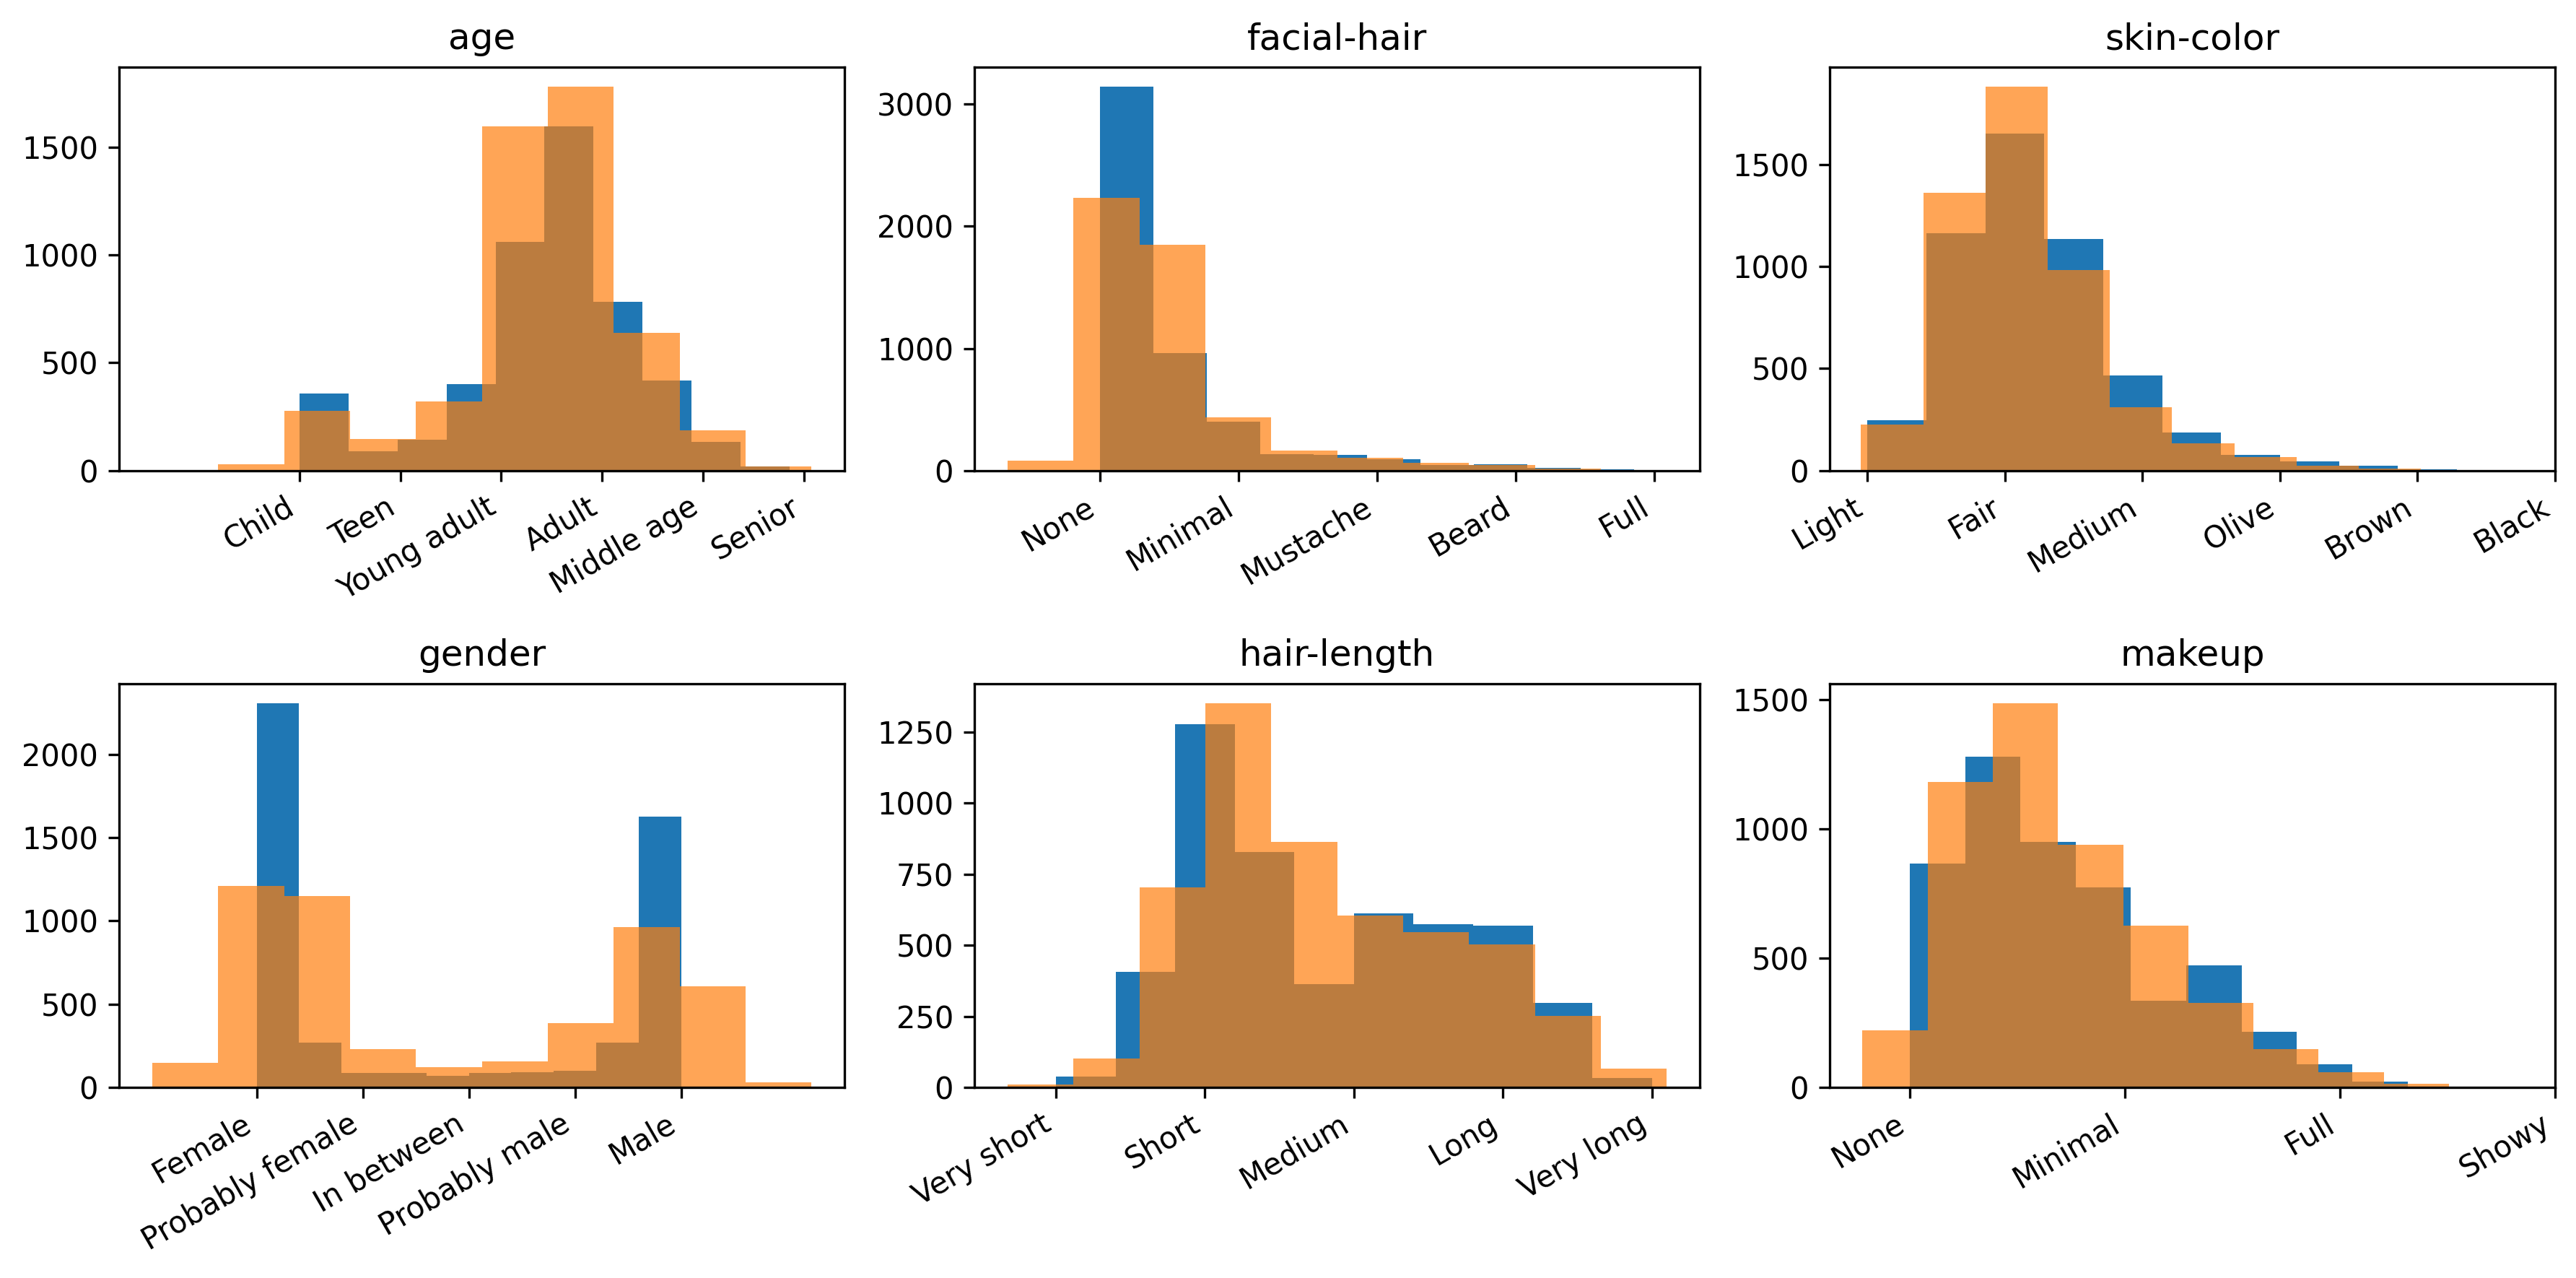

In [11]:
plt.figure(figsize=(12, 6), dpi=300)
R, C = 2, 3
for i, attr in enumerate(attrs):
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    plt.hist(attr_mat[:, i])
    plt.hist(preds[:, i], alpha=0.7)
    labs = annotations_dict_names[attr]
    plt.xticks(range(len(labs)), labs, rotation=30, ha='right')
plt.tight_layout()

**pick bounds**

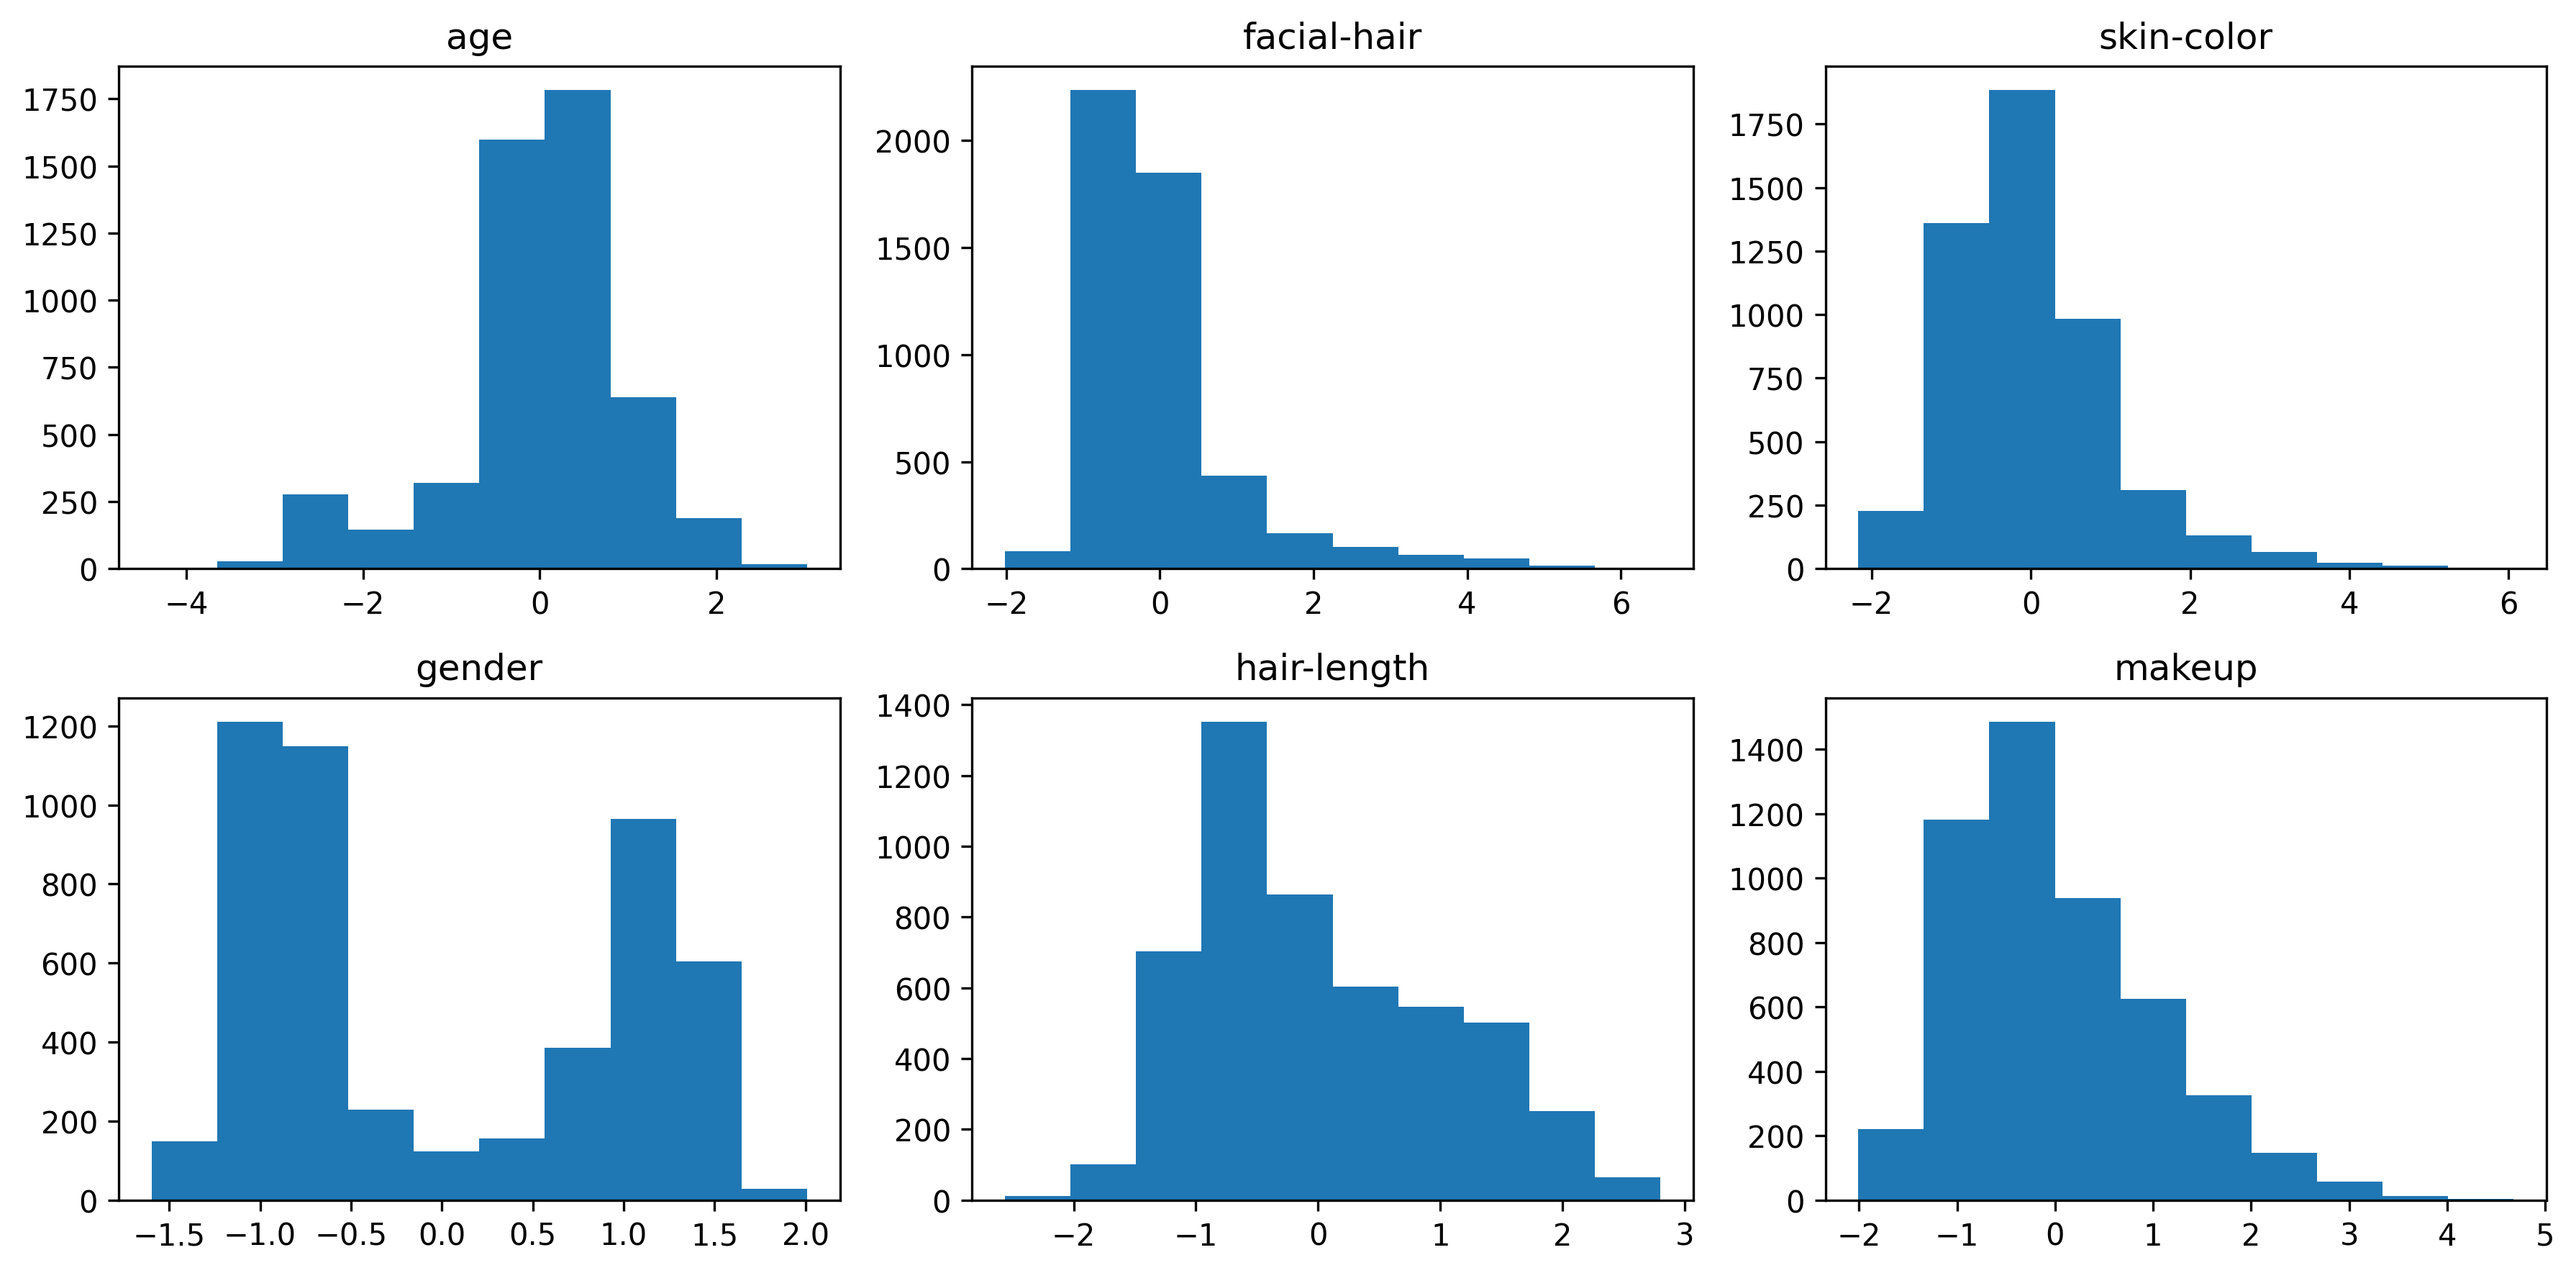

In [12]:
plt.figure(figsize=(12, 6), dpi=300)
R, C = 2, 3
preds = normalize_mat(preds)
for i, attr in enumerate(attrs):
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    plt.hist(preds[:, i])
    labs = annotations_dict_names[attr]
#     plt.xticks(range(len(labs)), labs, rotation=30, ha='right')
plt.tight_layout()

# now let's walk in face space

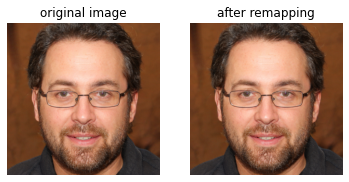

In [57]:
N_IMS = 5
z0 = X[0:1]
a = m(torch.Tensor(z0))
z = util.detach(m(a, rev=True))
assert np.allclose(z0, z, atol=1e-6), 'inversion was unsuccesful'
images = GAN.gen(np.vstack((z0, z)))
R = 1
C = 2
plt.subplot(R, C, 1)
plt.title('original image')
util.imshow(images[0])

plt.subplot(R, C, 2)
plt.title('after remapping')
util.imshow(images[1])

plt.show()
# attrs = np.zeros((N_IMS, 512))